<a href="https://colab.research.google.com/github/minertom/Graph-Attention-Networks-with-Pytorch-Geometric/blob/main/Graph_Attention_networks_with_Pytorch_Geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#!pip install pytorch_geometric
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#Installing build dependencies ... done
#Getting requirements to build wheel ... done
#Preparing metadata (pyproject.toml) ... done
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import (GCNConv, GATConv)
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import (NormalizeFeatures, RandomNodeSplit)
from torch_geometric.data import Data
from torch_geometric import seed_everything

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.manifold import TSNE
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)
plt.style.use('dark_background')
accuracy_list = []

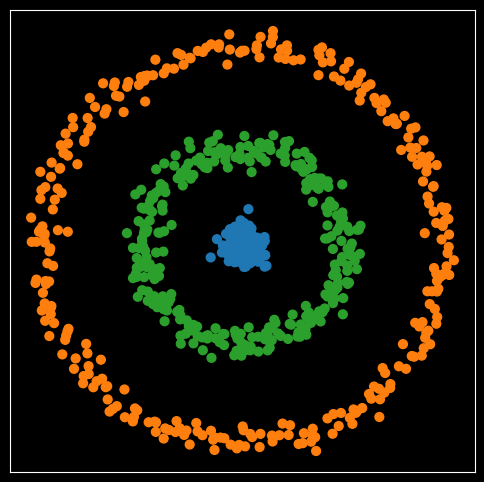

In [3]:
X, y = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=0.15, random_state=random_seed)
# center at the origin
X = X - np.mean(X, axis=0)

X1, y1 = make_circles(n_samples=600, noise=0.04, factor=0.5, random_state=random_seed)
# add 1 to (make_circles) labels to account for (make_blobs) label
y1 = y1 + 1
# increase the radius
X1 = X1*3

X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

plot_colors = cm.tab10.colors
y_colors = np.array(plot_colors)[y]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_colors)

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()

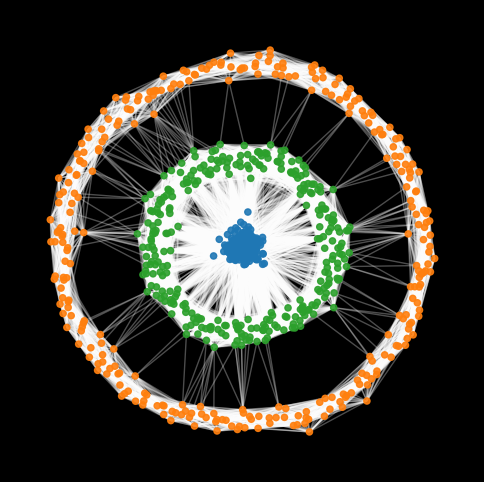

In [4]:
# An n by n matrix, where each element represents the similarity between a pair of samples
sigma = 1
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1)
A = np.exp(A / (2* sigma**2))
np.fill_diagonal(A, 0)

# only keep edges with a value greater than 0.5
A1 = np.copy(A)
A1[A1 < 0.5] = 0
G = nx.from_numpy_array(A1)

plt.figure(figsize=(6,6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=X, node_size=20, node_color=y_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos=X, edge_color="white", alpha=0.3)
plt.show()

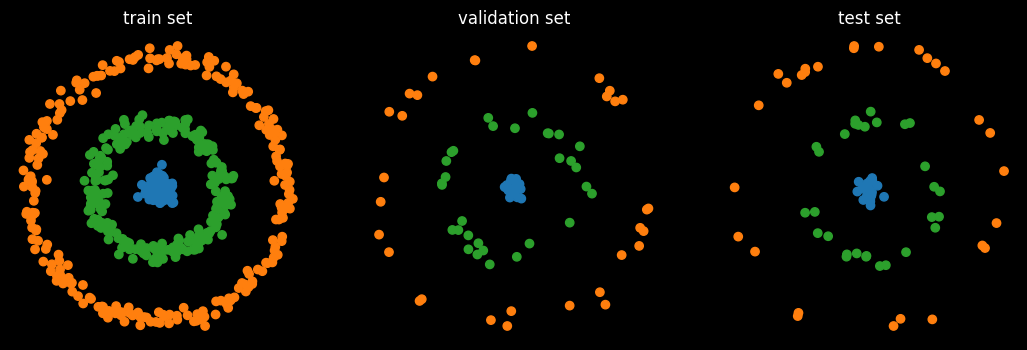

In [5]:
A = A1
num_features = X.shape[1]
num_classes = np.unique(y).shape[0]

# create an edge list out of the adjacency matrix
edge_index, _ = from_scipy_sparse_matrix(sparse.csr_matrix(A))
# create a torch_geometric Data instance
data_synthetic = Data(x=torch.from_numpy(X.astype(np.float32)), edge_index=edge_index, y=torch.from_numpy(y))
# create train/val/test masks with 80%/10%/10%
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data_synthetic = split(data_synthetic)
data_synthetic
Data(x=[1000, 2], edge_index=[2, 96996], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
idxs = [data_synthetic.train_mask, data_synthetic.val_mask, data_synthetic.test_mask]
plt_label = ['train set', 'validation set', 'test set']
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].scatter(X[idx, 0], X[idx, 1], color=y_colors[idx])

plt.show()

In [6]:
def visualize(h, color): # a helper function for visualization
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

In [7]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels*heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
model = GAT(hidden_channels=16, heads=8)
print(model)
#GAT(
#  (conv1): GATConv(2, 16, heads=8)
#  (conv2): GATConv(128, 3, heads=1)
#)
def train(data, mask, GNN_flag):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      if GNN_flag:
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
      else:
        out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data, mask, GNN_flag):
      model.eval()
      if GNN_flag:
        out = model(data.x, data.edge_index)
      else:
        out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

GAT(
  (conv1): GATConv(2, 16, heads=8)
  (conv2): GATConv(128, 3, heads=1)
)


In [8]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_synthetic, data_synthetic.train_mask, GNN_flag=True)
    val_acc = test(data_synthetic, data_synthetic.val_mask, GNN_flag=True)
    test_acc = test(data_synthetic, data_synthetic.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'synthetic', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.1202, Val: 0.4125, Test: 0.4000
Epoch: 002, Loss: 1.0347, Val: 0.7375, Test: 0.6750
Epoch: 003, Loss: 1.0121, Val: 0.6750, Test: 0.6375
Epoch: 004, Loss: 0.9984, Val: 0.6375, Test: 0.6000
Epoch: 005, Loss: 0.9877, Val: 0.6375, Test: 0.5875
Epoch: 006, Loss: 0.9623, Val: 0.6625, Test: 0.6250
Epoch: 007, Loss: 0.9329, Val: 0.7125, Test: 0.6750
Epoch: 008, Loss: 0.9047, Val: 0.7750, Test: 0.7125
Epoch: 009, Loss: 0.8687, Val: 0.7750, Test: 0.7000
Epoch: 010, Loss: 0.8472, Val: 0.7750, Test: 0.6875
Epoch: 011, Loss: 0.8008, Val: 0.7750, Test: 0.6750
Epoch: 012, Loss: 0.7800, Val: 0.7750, Test: 0.6750
Epoch: 013, Loss: 0.7413, Val: 0.7750, Test: 0.7125
Epoch: 014, Loss: 0.6892, Val: 0.7750, Test: 0.7125
Epoch: 015, Loss: 0.6432, Val: 0.7750, Test: 0.7125
Epoch: 016, Loss: 0.6360, Val: 0.7750, Test: 0.7125
Epoch: 017, Loss: 0.5994, Val: 0.7375, Test: 0.6875
Epoch: 018, Loss: 0.5827, Val: 0.7250, Test: 0.6750
Epoch: 019, Loss: 0.5397, Val: 0.7250, Test: 0.6750
Epoch: 020, 

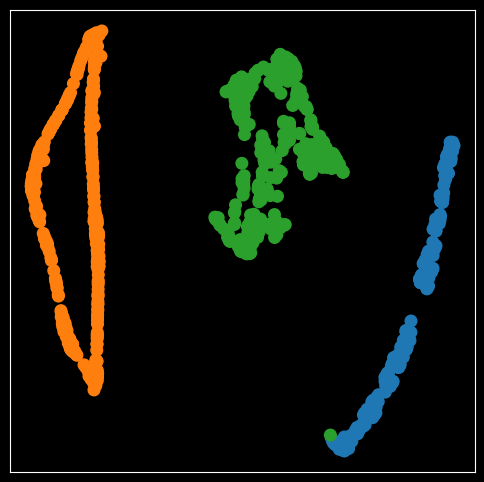

In [9]:
model.eval()
out = model(data_synthetic.x, data_synthetic.edge_index)
visualize(out, y_colors)

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=2, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


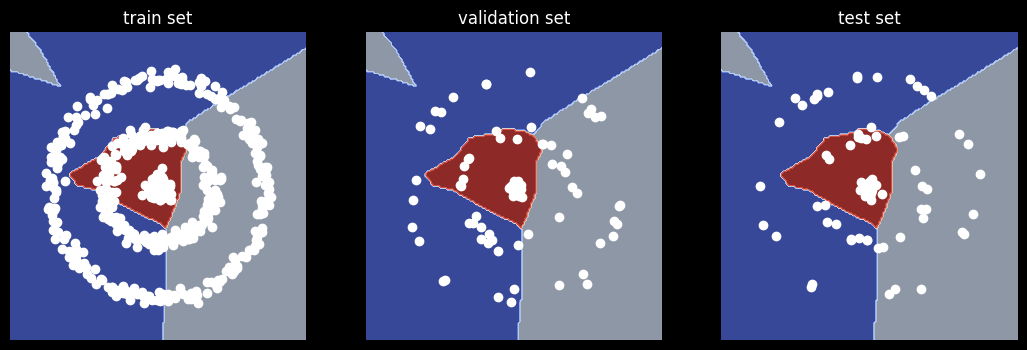

In [11]:
h = .05  # step size in the mesh
# create a mesh to plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plot_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

# evaluate all the points in plot_mesh
model.eval()
out = model(plot_mesh)
pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = pred.reshape(xx.shape).detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].contourf(xx, yy, pred, cmap='coolwarm', alpha=0.7)
  axs[i].scatter(X[idx, 0], X[idx, 1], color='white')

plt.show()

In [12]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16, heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_Cora, data_Cora.train_mask, GNN_flag=True)
    val_acc = test(data_Cora, data_Cora.val_mask, GNN_flag=True)
    test_acc = test(data_Cora, data_Cora.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9467, Val: 0.4160, Test: 0.4190
Epoch: 002, Loss: 1.9085, Val: 0.7460, Test: 0.7430
Epoch: 003, Loss: 1.8702, Val: 0.7940, Test: 0.7960
Epoch: 004, Loss: 1.8284, Val: 0.8020, Test: 0.7890
Epoch: 005, Loss: 1.7846, Val: 0.7880, Test: 0.7810
Epoch: 006, Loss: 1.7359, Val: 0.7780, Test: 0.7690
Epoch: 007, Loss: 1.6892, Val: 0.7620, Test: 0.7600
Epoch: 008, Loss: 1.6328, Val: 0.7540, Test: 0.7540
Epoch: 009, Loss: 1.5729, Val: 0.7600, Test: 0.7570
Epoch: 010, Loss: 1.5154, Val: 0.7660, Test: 0.7590
Epoch: 011, Loss: 1.4557, Val: 0.7860, Test: 0.7740
Epoch: 012, Loss: 1.3856, Val: 0.7840, Test: 0.7810
Epoch: 013, Loss: 1.3159, Val: 0.7880, Test: 0.7860
Epoch: 014, Loss: 1.2474, Val: 0.7940, Test: 0.7930
Epoch: 015, Loss: 1.1750, Val: 0.7900, Test: 0.7920
Epoch: 016, Loss: 1.1035, Val: 0.7900, Test: 0.7910
Epoch: 017, Loss: 1.0421, Val: 0.7840, Test: 0.7920
Epoch: 018, Loss: 0.9732, Val: 0.7880, Test: 0.7980
Epoch: 019, Loss: 0.9180, Val: 0.7940, Test: 0.8010
Epoch: 020, 

In [14]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_Cora, data_Cora.train_mask, GNN_flag=False)
    val_acc = test(data_Cora, data_Cora.val_mask, GNN_flag=False)
    test_acc = test(data_Cora, data_Cora.test_mask, GNN_flag=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['MLP', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9565, Val: 0.3160, Test: 0.3180
Epoch: 002, Loss: 1.9179, Val: 0.1740, Test: 0.1690
Epoch: 003, Loss: 1.8632, Val: 0.2100, Test: 0.2030
Epoch: 004, Loss: 1.7708, Val: 0.2960, Test: 0.2910
Epoch: 005, Loss: 1.6755, Val: 0.4060, Test: 0.3750
Epoch: 006, Loss: 1.5373, Val: 0.4000, Test: 0.4190
Epoch: 007, Loss: 1.4155, Val: 0.4580, Test: 0.4660
Epoch: 008, Loss: 1.3027, Val: 0.4680, Test: 0.4830
Epoch: 009, Loss: 1.0968, Val: 0.5140, Test: 0.5150
Epoch: 010, Loss: 0.9550, Val: 0.5460, Test: 0.5390
Epoch: 011, Loss: 0.9219, Val: 0.5440, Test: 0.5410
Epoch: 012, Loss: 0.7943, Val: 0.5540, Test: 0.5470
Epoch: 013, Loss: 0.6456, Val: 0.5400, Test: 0.5300
Epoch: 014, Loss: 0.6790, Val: 0.5160, Test: 0.5200
Epoch: 015, Loss: 0.5752, Val: 0.5540, Test: 0.5490
Epoch: 016, Loss: 0.5513, Val: 0.5800, Test: 0.5750
Epoch: 017, Loss: 0.5200, Val: 0.5880, Test: 0.5810
Epoch: 018, Loss: 0.4679, Val: 0.5940, Test: 0.5910
Epoch: 019, Loss: 0.5048, Val: 0.5840, Test: 0.5930
Epoch: 020, 

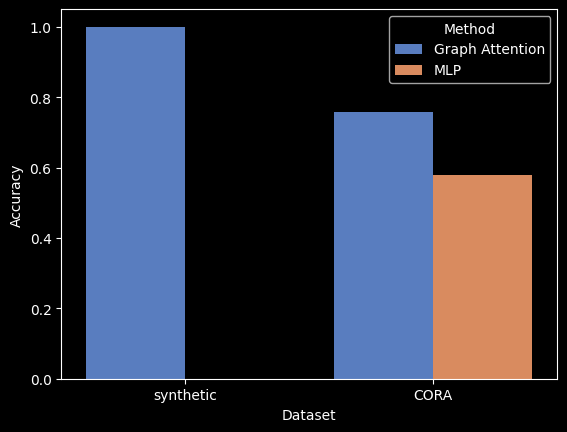

In [15]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Dataset', 'Accuracy'))
sns.barplot(df,x='Dataset', y='Accuracy', hue='Method', palette="muted")
plt.show()